<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
<div hidden>
    $$
    \newcommand{\reals}{\mathbb{R}}
    \newcommand{\naturals}{\mathbb{N}}
    \newcommand{\integers}{\mathbb{Z}}
    \newcommand{\prob}{\mathbb{P}}
    \newcommand{\expect}{\mathbb{E}}
    \newcommand{\b}[1]{\mathbf{#1}}
    \newcommand{\bs}[1]{\boldsymbol{#1}}
    \newcommand{\c}[1]{\mathcal{#1}}
    \newcommand{mat}[2]{\left[\,\begin{array}{#1}#2\end{array}\,\right]}
    $$
</div>

# COMPSCI 371 Homework 3

_**Group Members:**_

### Problem 0 (3 points)

## Part 1: Stochastic Gradient Descent

In [6]:
import urllib.request
import ssl
from os import path as osp
import shutil


def retrieve(file_name, semester='fall24', homework=3):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        context = ssl._create_unverified_context()
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci371/homework/{}/{}'
        url = fmt.format(semester, homework, file_name)
        with urllib.request.urlopen(url, context=context) as response:
            with open(file_name, 'wb') as file:
                shutil.copyfileobj(response, file)
        print('Downloaded file {}'.format(file_name))

In [7]:
retrieve('helpers.py', homework=2)

Using previously downloaded file helpers.py


In [8]:
from helpers import Stepper
from autograd import numpy as anp
import numpy as snp


def gradient_descent(
    f, z, alpha, min_step=1.e-6, max_iter=10000, history=False, **kwargs
):
    step = Stepper(f, z, alpha, history=history, **kwargs)
    z, fz, gz = anp.copy(z), step.fz0, step.gz0
    for k in range(max_iter):
        s, z, fz, gz = step(z, **kwargs)
        if anp.linalg.norm(s) < min_step:
            break
    step.show_history()
    return fz, z, k

In [9]:
import pickle


file_name = 'students.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    students = pickle.load(file)

Using previously downloaded file students.pkl


In [10]:
print(students.features)
print(students.values)

['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
Performance Index


### Problem 1.1

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

x_train = students.train.x
y_train = students.train.y
x_test = students.test.x
y_test = students.test.y

# Train the model
model = LinearRegression()
model.fit(x_train, y_train)

# Function to compute RMS
def rms(v, x, y):
    y_pred = model.predict(x)
    numerator = np.sqrt(np.mean((y - y_pred) ** 2))
    denominator = np.sqrt(np.mean(y ** 2))
    return numerator / denominator

print("Model coefficients:", model.coef_)
print("Model intercept:", model.intercept_)
print("Relative RMS error (Training): {:.4f}".format(rms(model.coef_, x_train, y_train)))
print("Relative RMS error (Testing): {:.4f}".format(rms(model.coef_, x_test, y_test)))


Model coefficients: [0.07365753 0.17634194 0.00817971 0.00533195]
Model intercept: 0.5523395643090314
Relative RMS error (Training): 0.0350
Relative RMS error (Testing): 0.0355


Performance: The relative RMS error on the training set was computed to be 0.0350, which indicates that the model fits the training data well. A relative RMS error of 0.0350 suggests that the residuals (the differences between the predicted and actual values) are small relative to the magnitude of the actual values.

Generalization: The similarity of the relative RMS error from the training set (0.0350) to the testing set (0.0355) indicates effective generalization. There's no significant increase or decrease in error when the model is applied to the test data. This means that the data is not overfitting nor underfitting. For example, if the model was overfitting, that is kind of just memorizing the training data, that would lead to a higher testing error. Also, we know the model is not underfitting since it reports a low, comparable test accuracy which wouldn't be the case if our model had high bias. Since the relative RMS errors of the training set and test set are both low and similar to each other, our model is generalizing well.

### Problem 1.2

In [12]:
def risk(v, x=None, y=None, indices=None):
    if indices is None:
        indices = range(len(y))  # Use the entire dataset if no indices are provided
    b = v[0]
    w = v[1:]
    predictions = b + anp.dot(x[indices], w)
    errors = predictions - y[indices]
    mean_squared_error = anp.mean(anp.square(errors))
    return mean_squared_error

b = 5
w = anp.array([1, 2, 3, 4])
v = anp.concatenate(([b], w))

x_train = students.train.x
y_train = students.train.y

print("Risk for the entire dataset: {:.4f}".format(risk(v, x_train, y_train)))
print("Risk for the first 100 samples: {:.4f}".format(risk(v, x_train, y_train, indices=range(100))))
print("Risk for the last 100 samples: {:.4f}".format(risk(v, x_train, y_train, indices=range(-100, 0))))


Risk for the entire dataset: 50.1153
Risk for the first 100 samples: 44.3617
Risk for the last 100 samples: 53.2272


### Problem 1.3

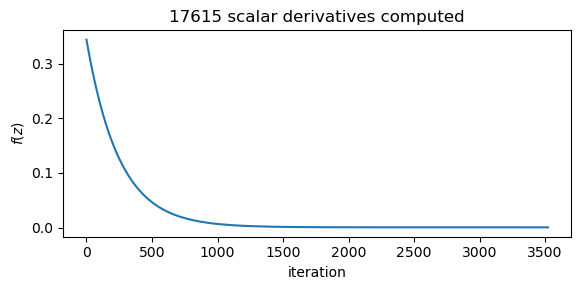

v: [0.55186512 0.07362859 0.17619758 0.0081941  0.00536668]
training: 0.035038897495906655
testing: 0.0354565042741402


In [15]:
#WE NEED TO CHANGE THIS CODE
def sgd(
    h, v, alpha=1.e-3, x=students.train.x, y=students.train.y, batch_size=None,
    min_step=1.e-6, max_epochs=5000, history=True, **kwargs
):

    step = Stepper(h, v, alpha, history=history, x=x, y=y, **kwargs)
    v = anp.copy(v)

    num_batches = 1 if not batch_size else len(x) // batch_size
    batch_size = batch_size if batch_size else x.shape[0]

    num_epochs = 0

    prev_v = anp.copy(v)
    for k in range(max_epochs):
        num_epochs = k
        rng = np.random.default_rng()
        ordering = rng.permutation(len(x))

        for i in range(num_batches):
            indices = ordering[i*batch_size:min((i+1)*batch_size, len(x))]
            v = step(v, x=x, y=y, indices=indices)[1]

        if anp.linalg.norm(anp.array(prev_v) - anp.array(v)) < min_step:
            break

        prev_v = anp.copy(v)


    step.show_history()

    return v, num_epochs

v = anp.zeros(5)
v, num_epochs = sgd(risk, v)

print("v:", v)
print("training:",rms(v, students.train.x, students.train.y))
print("testing:",rms(v, students.test.x, students.test.y))

### Problem 1.4 (Exam Style)

When batch_size=None in the SGD method, the entire dataset is used for each update, effectively reducing the stochastic gradient descent (SGD) to regular gradient descent (GD). In this setting, each update considers all data points, which is precisely what happens in regular gradient descent. Thus, SGD with batch_size=None is equivalent to gradient descent.

### Problem 1.5

### Problem 1.6 (Exam Style)

### Problem 1.7 (Exam Style)

## Part 2: Linear Score-Based Classifiers

### Problem 2.1 (Exam Style)

### Problem 2.2 (Exam Style)

### Problem 2.3 (Exam Style)

### Problem 2.4

In [5]:
import pickle

file_name = 'classifiers.pkl'
retrieve(file_name)
with open(file_name, 'rb') as file:
    classifiers = pickle.load(file)

Using previously downloaded file classifiers.pkl


In [6]:
print(students.features)
print(students.values)


['Hours Studied', 'Previous Scores', 'Sleep Hours', 'Sample Question Papers Practiced']
Performance Index


### Problem 2.5

## Part 3: Linear Classification of Handwritten Digits 

In [7]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from types import SimpleNamespace

digits = datasets.load_digits()
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, train_size=900, shuffle=False
)
mnist = SimpleNamespace(
    train=SimpleNamespace(x=x_train, y=y_train),
    test=SimpleNamespace(x=x_test, y=y_test)
)

### Problem 3.1

### Problem 3.2 (Exam Style)